In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from helpers.helper_functions import *

# Handling text 2 exercise
[Handling text exercisses ADApted drom ADA 2018 final exam]

The Sheldon Cooper we all know and love (OK, some of us might not know him, and some might not love him) from the TV series "The Big Bang Theory" has gotten into an argument with Leonard from the same TV show. Sheldon insists that he knows the show better than anyone, and keeps making various claims about the show, which neither of them know how to prove or disprove. The two of them have reached out to you ladies and gentlemen, as data scientists, to help them. You will be given the full script of the series, with information on the episode, the scene, the person saying each dialogue line, and the dialogue lines themselves.

Leonard has challenged several of Sheldon's claims about the show, and throughout this exam you will see some of those and you will get to prove or disprove them, but remember: sometimes, we can neither prove a claim, nor disprove it!

## Task A: Picking up the shovel

**Note: You will use the data you preprocess in this task in all the subsequent ones.**

Our friends' argument concerns the entire show. We have given you a file in the `data/` folder that contains the script of every single episode. New episodes are indicated by '>>', new scenes by '>', and the rest of the lines are dialogue lines. Some lines are said by multiple people (for example, lines indicated by 'All' or 'Together'); **you must discard these lines**, for the sake of simplicity. However, you do not need to do it for Q1 in this task -- you'll take care of it when you solve Q2.

**Q1**. Your first task is to extract all lines of dialogue in each scene and episode, creating a dataframe where each row has the episode and scene where a dialogue line was said, the character who said it, and the line itself. You do not need to extract the proper name of the episode (e.g. episode 1 can appear as "Series 01 Episode 01 - Pilot Episode", and doesn't need to appear as "Pilot Episode"). Then, answer the following question: In total, how many scenes are there in each season? We're not asking about unique scenes; the same location appearing in two episodes counts as two scenes. You can use a Pandas dataframe with a season column and a scene count column as the response.

**Note: The data refers to seasons as "series".**

In [41]:
# df columns
columns = ['season', 'episode', 'scene', 'character', 'line']
season = ""
episode = ""
scene = ""
character = ""
line = ""
lines = [] # empty template to host the data

# import raw data 
with open("data/all_scripts.txt", "r", encoding="utf8") as f: # specify the encoding else crash...
    # loop over all lines of the document, read each individual line
    for line in f.readlines():
        # the ifs here are really cool: they enable to repeat the season and episode name for each dialogue that belongs to this pair without needing to recompute!!! 
        # only change the season and epiose if we encounter a new pair!!
        if line.startswith(">>"): 
            season = line[10:12]
            episode = line[21:-1]
            continue # go to the next line if we are on a line that contains season and episode information 
        if line.startswith(">"):
            scene = line[2:-2]
            continue # go to next line if we are on a line that contains scene infromation 

        character, line = line.split(": ", 1) # 1 means we split one time to get 2 instances
        lines.append([season, episode, scene, character, line]) # add rows for that particular line

data = pd.DataFrame(lines, columns=columns)
data

,season,episode,scene,character,line
0,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,So if a photon is directed through a plane wit...
1,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,"Agreed, what’s your point?\n"
2,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,"There’s no point, I just think it’s a good ide..."
3,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,Excuse me?\n
4,01,01 – Pilot Episode,A corridor at a sperm bank,Receptionist,Hang on.\n
...,...,...,...,...,...
51287,10,24 – The Long Distance Dissonance,Sheldon’s office,Ramona,"Mmm. No big deal, I enjoy spending time with y..."
51288,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,"And I with you. Question, are you seeking a ro..."
51289,10,24 – The Long Distance Dissonance,Sheldon’s office,Ramona,What if I were?\n
51290,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,"Well, that would raise a number of problems. W..."


In [42]:
Q1 = data.groupby(["season", "episode", "scene"]).size().reset_index(name="num_lines").groupby("season").size().reset_index(name="num_scenes")
Q1

,season,num_scenes
0,01,157
1,02,205
2,03,193
3,04,219
4,05,198
5,06,211
6,07,207
7,08,191
8,09,177
9,10,189


In [43]:
# this is wrong because it counts the number of lines that have been said in each season! 
data.groupby(["season"]).count()

,episode,scene,character,line
season,,,,
01,4136,4136,4136,4136
02,5238,5238,5238,5238
03,5030,5030,5030,5030
04,5604,5604,5604,5604
05,4847,4847,4847,4847
06,4885,4885,4885,4885
07,5345,5345,5345,5345
08,5269,5269,5269,5269
09,5418,5418,5418,5418


**Q2**. Now, let's define two sets of characters: all the characters, and recurrent characters. Recurrent characters are those who appear in more than one episode. For the subsequent sections, you will need to have a list of recurrent characters. Assume that there are no two _named characters_ (i.e. characters who have actual names and aren't referred to generically as "little girl", "grumpy grandpa", etc.) with the same name, i.e. there are no two Sheldons, etc. Generate a list of recurrent characters who have more than 90 dialogue lines in total, and then take a look at the list you have. If you've done this correctly, you should have a list of 20 names. However, one of these is clearly not a recurrent character. Manually remove that one, and print out your list of recurrent characters. To remove that character, pay attention to the _named character_ assumption we gave you earlier on. **For all the subsequent questions, you must only keep the dialogue lines said by the recurrent characters in your list.**

In [58]:
# all characters, number of episodes in which they appear, total number of lines that they say
Q2 = data.groupby(["character", "episode"]).size().reset_index(name="num_lines").groupby("character").agg({'episode': 'size',
                                                                                                            'num_lines': 'sum'}).reset_index()
# remove non-recurrent characters
Q2 = Q2[Q2['episode'] > 1]
# get characters that speak more than 90 lines in total
Q2 = Q2[Q2['num_lines'] > 90]
display(Q2)
print(len(Q2))

# remove the non-named character
Q2 = Q2[~(Q2['character'] == 'Man')]

# list of main characters 
main_characters = Q2.character.tolist()

,character,episode,num_lines
10,Amy,154,3472
13,Arthur,4,130
20,Bernadette,161,2690
21,Bert,6,95
23,Beverley,5,162
52,Emily,17,164
71,Howard,231,5872
90,Kripke,8,106
95,Leonard,231,9829
98,Leslie,7,116


20


We end up with a list of 19 characters that have more than 90 lines and that appear in more than one episode. Those are the important characters :)) For the rest of the exercice, we will work on dialogue lines comming axclusively from those 19 protagonists, so let's filter the original data accordingly!

In [59]:
data = data[data["character"].isin(main_characters)]
data

,season,episode,scene,character,line
0,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,So if a photon is directed through a plane wit...
1,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,"Agreed, what’s your point?\n"
2,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,"There’s no point, I just think it’s a good ide..."
3,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,Excuse me?\n
5,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,"One across is Aegean, eight down is Nabakov, t..."
...,...,...,...,...,...
51284,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,"Uh, breakfast yes, lunch no. I did have a coug..."
51286,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,How thoughtful. Thank you.\n
51288,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,"And I with you. Question, are you seeking a ro..."
51290,10,24 – The Long Distance Dissonance,Sheldon’s office,Sheldon,"Well, that would raise a number of problems. W..."


## Task B: Read the scripts carefully

### Part 1: Don't put the shovel down just yet

**Q3**. From each dialogue line, replace punctuation marks (listed in the EXCLUDE_CHARS variable provided in `helpers/helper_functions.py`) with whitespaces, and lowercase all the text. **Do not remove any stopwords, leave them be for all the questions in this task.**

In [60]:
def process_lines(line):
    for char in EXCLUDE_CHARS: 
        line = line.replace(char, ' ')
    line = line.replace("\n", ' ') # artefact from Q1
    return line.lower()

In [61]:
# your code goes here
data["line"] = data["line"].apply(process_lines)
data.head()

C:\Users\fricl\AppData\Local\Temp\ipykernel_21608\661599251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["line"] = data["line"].apply(process_lines)


,season,episode,scene,character,line
0,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,so if a photon is directed through a plane wit...
1,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,agreed what s your point
2,01,01 – Pilot Episode,A corridor at a sperm bank,Sheldon,there s no point i just think it s a good ide...
3,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,excuse me
5,01,01 – Pilot Episode,A corridor at a sperm bank,Leonard,one across is aegean eight down is nabakov t...


**Q4**. For each term, calculate its "corpus frequency", i.e. its number of occurrences in the entire series. Visualize the distribution of corpus frequency using a histogram. Explain your observations. What are the appropriate x and y scales for this plot?

In [63]:
# your code goes here
corpus_frequency = pd.concat([pd.Series(row['line'].split(' ')) for _, row in data.iterrows()]).reset_index()
corpus_frequency.columns = ["Frequency", "Word"]
corpus_frequency = corpus_frequency.groupby("Word").count().reset_index()
corpus_frequency

,Word,Frequency
0,,177788
1,0,5
2,00,5
3,000,33
4,000lb,1
...,...,...
21122,…tion,1
21123,…when,1
21124,…who,1
21125,‭yeah,1


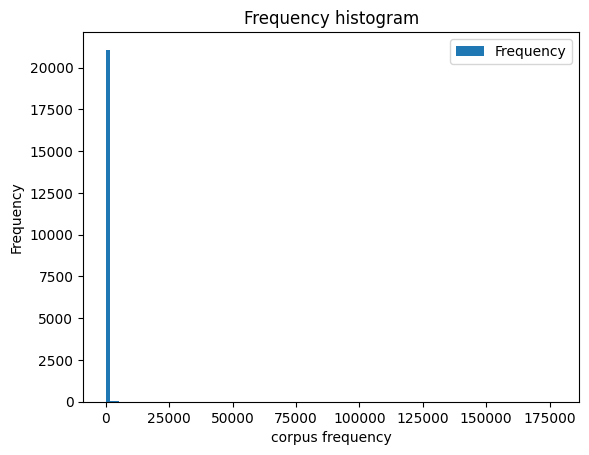

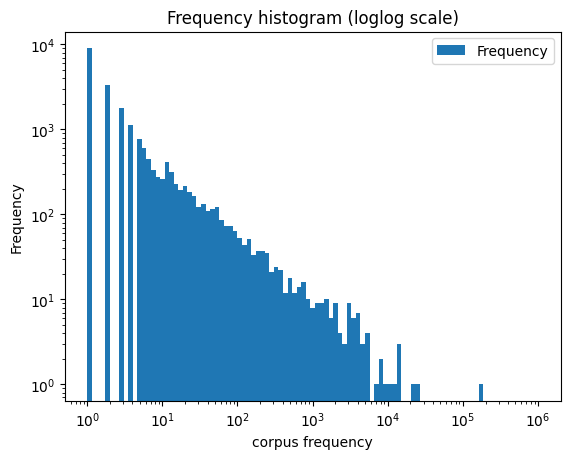

In [66]:
corpus_frequency.plot.hist(column=["Frequency"], bins=100, title="Frequency histogram")
plt.xlabel('corpus frequency')
corpus_frequency.plot.hist(column=["Frequency"], loglog=True, bins=np.logspace(0, 6, 100),
                           title="Frequency histogram (loglog scale)");
plt.xlabel('corpus frequency')
plt.show()

### Part 2: Talkativity
**Q5**. For each of the recurrent characters, calculate their total number of words uttered across all episodes. Based on this, who seems to be the most talkative character?

In [81]:
# your code goes here
lines_per_character = data.groupby('character').agg({'line': 'sum'}).reset_index()
lines_per_character['words'] = lines_per_character['line'].apply(lambda row: len(row.split()))
lines_per_character.sort_values(by='words', ascending=False).head(1)

,character,line,words
15,Sheldon,so if a photon is directed through a plane wit...,185388


## Task D: The Detective's Hat

Sheldon claims that given a dialogue line, he can, with an accuracy of above 70%, say whether it's by himself or by someone else. Leonard contests this claim, since he believes that this claimed accuracy is too high.

**Q6**. Divide the set of all dialogue lines into two subsets: the training set, consisting of all the seasons except the last two, and the test set, consisting of the last two seasons.

In [85]:
# your code goes here
train = data[~(data['season'].isin(['10', '09']))]
test = data[data['season'].isin(['10', '09'])]

**Q7**. Find the set of all words in the training set that are only uttered by Sheldon. Is it possible for Sheldon to identify himself only based on these? Use the test set to assess this possibility, and explain your method.

In [174]:
# get words said by each character in the train set 
line_per_character = train.groupby('character').agg({'line': 'sum'}).reset_index()
line_per_character['words'] = line_per_character['line'].apply(lambda row: row.split())
line_per_character['num_words'] = line_per_character['words'].apply(lambda row: len(row))
line_per_character = line_per_character.sort_values(by='num_words', ascending=False)
line_per_character

,character,line,words,num_words
15,Sheldon,so if a photon is directed through a plane wit...,"[so, if, a, photon, is, directed, through, a, ...",150276
8,Leonard,agreed what s your point excuse me one acro...,"[agreed, what, s, your, point, excuse, me, one...",86041
12,Penny,oh hi hi oh that s nice oh okay well g...,"[oh, hi, hi, oh, that, s, nice, oh, okay, well...",64771
6,Howard,wait till you see this it s a stephen hawking...,"[wait, till, you, see, this, it, s, a, stephen...",56505
14,Raj,it s fantastic unbelievable why smooth are...,"[it, s, fantastic, unbelievable, why, smooth, ...",47217
0,Amy,excuse me i m amy farrah fowler you re sheld...,"[excuse, me, i, m, amy, farrah, fowler, you, r...",27279
2,Bernadette,microbiology i don t understand i know i m ...,"[microbiology, i, don, t, understand, i, know,...",19208
16,Stuart,oh really blink twice if you re here against...,"[oh, really, blink, twice, if, you, re, here, ...",4656
10,Mrs Cooper,you did the right thing calling hi baby oh ...,"[you, did, the, right, thing, calling, hi, bab...",3311
13,Priya,oh sheldon you haven t changed a bit have y...,"[oh, sheldon, you, haven, t, changed, a, bit, ...",1940


In [192]:
words_sheldon = line_per_character[line_per_character['character'] == 'Sheldon']['words'].tolist()[0]
words_others = np.concatenate(line_per_character[line_per_character['character'] != 'Sheldon'].words.tolist())

print("words said by Sheldon:", len(words_sheldon))
print("words said by all others:", len(words_others))

words_by_only_sheldon = list(set(words_sheldon).difference(words_others))
print("words said ONLY by Sheldon:", len(words_by_only_sheldon))
print(sorted(words_by_only_sheldon))

words said by Sheldon: 150276
words said by all others: 321346
words said ONLY by Sheldon: 5269
['000lb', '01100111', '0700', '08', '102', '112', '114', '1175', '11n', '11pm', '12th', '140', '1487', '154', '15…', '1642', '165', '16th', '172', '1778', '17th', '180', '1800', '1852', '1855', '1863', '187', '1880s', '1890', '1890s', '1900s', '1908', '1917', '193', '1930s', '1935', '1936', '1940s', '1948', '1952', '1956', '1964', '1975', '1976', '1980', '1980s', '1989', '1992', '1993', '1995', '1998', '2000', '2004', '2005', '2007', '2009', '200million', '204', '209', '2099', '20th', '211', '21185', '212', '22nd', '23', '2311', '233', '246', '248', '2530', '288', '289', '28th', '290', '2am', '300', '300th', '30s', '30th', '311', '317', '32', '350', '359', '36', '366…', '367…', '37b', '3p', '3rd', '400lb', '41', '43', '446', '46', '47', '4d', '5027', '51', '52', '533', '61', '63345', '640', '67', '700', '7010', '704', '71', '74', '79', '800”', '802', '82', '840', '85', '87', '9352', '96', 'a

He has a lot of words that are proper to him. If a line contains one of the words that are uttered only by him, we know that this line is said by him. To test the claim, we need to find te percentage of lines in the train and test set that contain words uttered only by Sheldon! 

In [193]:
# for each line we need to see if it contains any of the words that are contained in the list 'words_by_only_sheldon'
train.loc[:, 'pred'] = train['line'].apply(lambda line: 'Sheldon' if len(set(words_by_only_sheldon).intersection(line.split())) != 0 else "don't know")
acc = len(train[train['character'] == train['pred']]) / len(train[train['character'] == 'Sheldon']) * 100
print("Train accuracy:", acc)

Train accuracy: 37.1349978840457


In [194]:
test.loc[:, 'pred'] = test.line.apply(lambda line: 'Sheldon' if len(set(line.split()).intersection(words_by_only_sheldon)) != 0 else "don't know")
acc = len(test[test['character'] == test['pred']]) /len(test[test['character'] == 'Sheldon']) * 100
print("Test accuracy:", acc)

Test accuracy: 14.617791685292802
